## Assignment: Image recognition
- Alumno 1: Reyes Castro, Didier Yamil (didier.reyes.castro@alumnos.upm.es)
- Alumno 2: San Millan Rodrigues, Nadine (n.srodrigues@alumnos.upm.es)
- Alumno 3: Sukhorukova, Anastasia (anastasia.s@alumnos.upm.es)

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-10-11 08:50:58.026066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760172658.248521      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760172658.311252      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [3]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [4]:
!pip install -q rasterio==1.3.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 88.5 MB/s eta 0:00:00:00:0100:01


In [5]:
import os, warnings, rasterio, numpy as np

DATA_ROOTS = [
    '/kaggle/input/xview/xview_recognition',
    '/kaggle/input/xview-recognition',  # por si el dataset tiene este nombre
]

def _resolve_xview_path(p):
    s = os.fspath(p).replace('\\', '/')
    if s.startswith('/kaggle/input/'):   # ya es absoluta → úsala tal cual
        return s
    # limpia posibles prefijos repetidos
    if 'xview_recognition/' in s:
        s = s.split('xview_recognition/', 1)[1]
    s = s.lstrip('/')
    # prueba en cada raíz conocida
    for root in DATA_ROOTS:
        cand = os.path.join(root, s)
        if os.path.exists(cand):
            return cand
    # último recurso: devuelve la primera candidata
    return os.path.join(DATA_ROOTS[0], s)

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    path = _resolve_xview_path(filename)
    with rasterio.open(path, 'r') as src:
        c = src.count
        img = np.zeros((src.height, src.width, c), dtype=src.profile['dtype'])
        for b in range(c):
            img[:, :, b] = src.read(b+1)
    return img


#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [6]:
import json

# Load database
json_file = '/kaggle/input/xview/xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [7]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [8]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 16871
Number of validation images: 1875


In [9]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout

print('Load model')
model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(len(categories)))
model.add(Activation('softmax'))
model.summary()

Load model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1760172678.848277      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760172678.849017      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           663 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,146,385 (294.29 MB)

 Trainable params: 77,145,005 (294.28 MB)

 Non-trainable params: 1,380 (5.39 KB)

In [10]:
from tensorflow.keras.optimizers import Adam

# Learning rate is changed to 0.001
opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [12]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [13]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 16
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [14]:
import math
import numpy as np

print('Training model')
epochs = 30
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/30


I0000 00:00:1760172687.256951     104 service.cc:148] XLA service 0x7969b0007c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760172687.257974     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760172687.257985     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760172687.821314     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1055 ━━━━━━━━━━━━━━━━━━━━ 2:25:32 8s/step - accuracy: 0.2500 - loss: 2.7521

I0000 00:00:1760172690.825567     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.3164 - loss: 2.0221
Epoch 1: val_accuracy improved from -inf to 0.42347, saving model to model.keras
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 754s 708ms/step - accuracy: 0.3165 - loss: 2.0220 - val_accuracy: 0.4235 - val_loss: 1.6798 - learning_rate: 0.0010
Epoch 2/30
1054/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4257 - loss: 1.6491
Epoch 2: val_accuracy improved from 0.42347 to 0.45280, saving model to model.keras
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 115s 109ms/step - accuracy: 0.4257 - loss: 1.6491 - val_accuracy: 0.4528 - val_loss: 1.6375 - learning_rate: 0.0010
Epoch 3/30
1054/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4626 - loss: 1.5478
Epoch 3: val_accuracy did not improve from 0.45280
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 96s 91ms/step - accuracy: 0.4627 - loss: 1.5478 - val_accuracy: 0.4352 - val_loss: 1.7579 - learning_rate: 0.0010
Epoch 4/30
1054/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4856 - loss: 1.4963

#### Validation
Compute validation metrics.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [16]:
import numpy as np

model.load_weights('model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

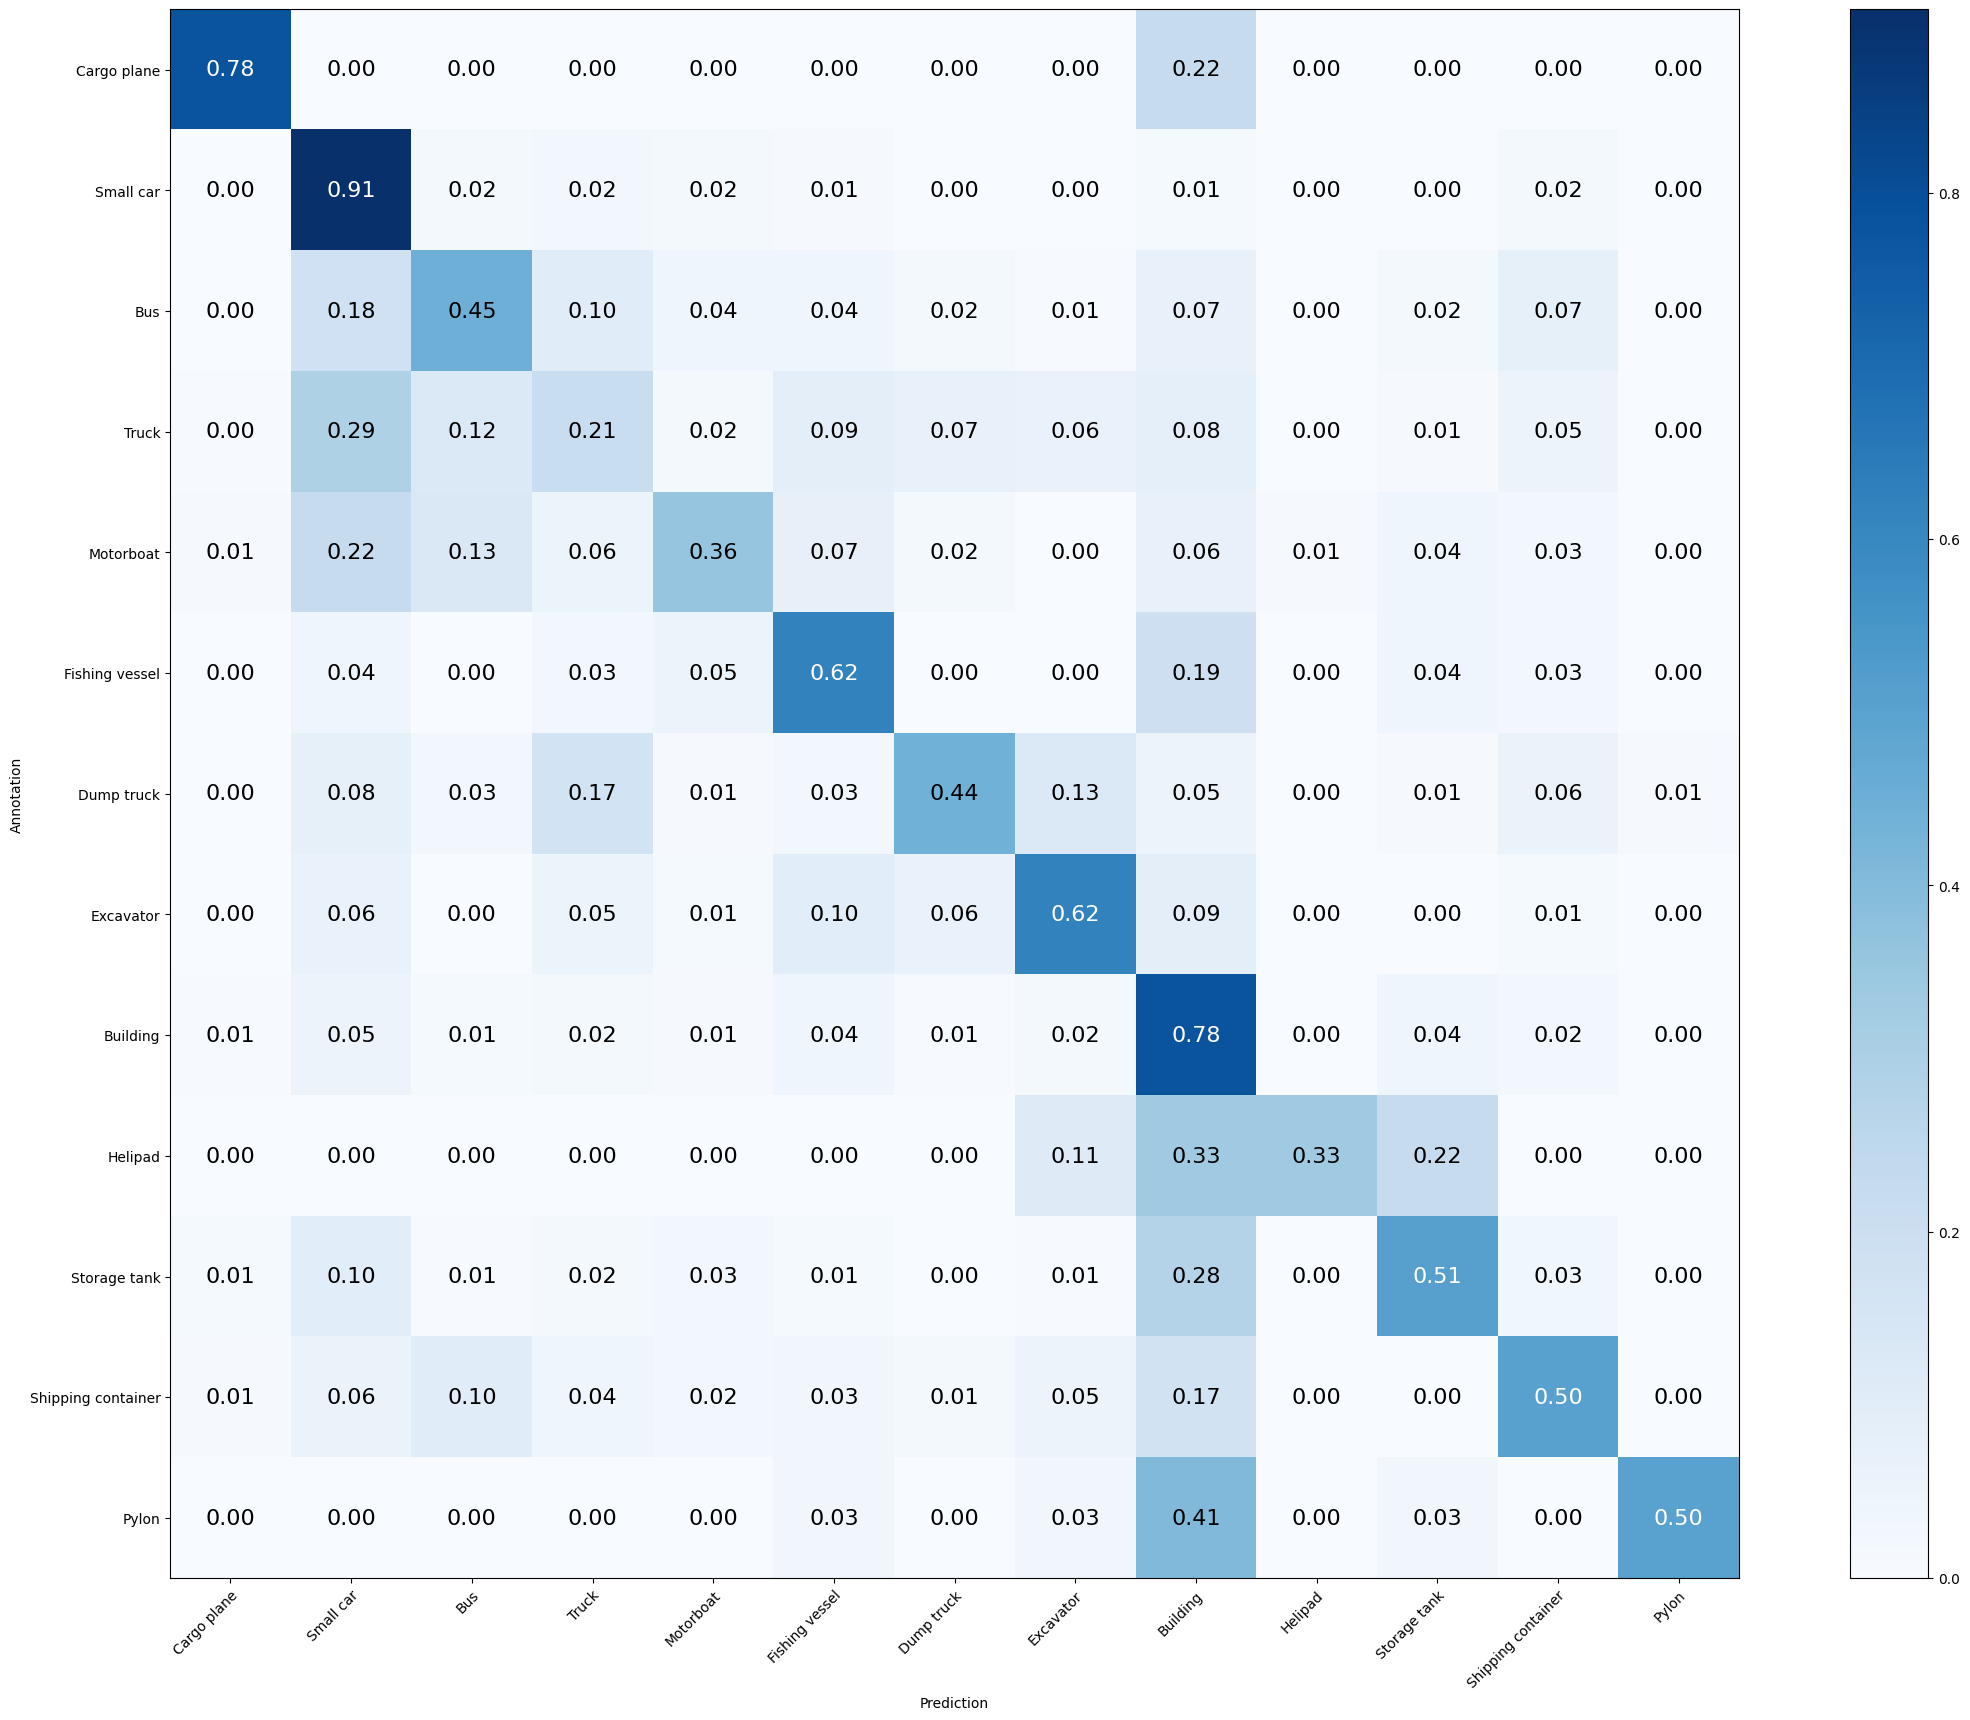

In [17]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [18]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 58.987%
Mean Recall: 53.852%
Mean Precision: 60.764%
> Cargo plane: Recall: 77.966% Precision: 86.792% Specificity: 99.615% Dice: 82.143%
> Small car: Recall: 90.578% Precision: 61.698% Specificity: 88.034% Dice: 73.399%
> Bus: Recall: 44.828% Precision: 51.656% Specificity: 95.708% Dice: 48.000%
> Truck: Recall: 21.162% Precision: 41.463% Specificity: 95.594% Dice: 28.022%
> Motorboat: Recall: 35.780% Precision: 54.930% Specificity: 98.188% Dice: 43.333%
> Fishing vessel: Recall: 61.644% Precision: 39.130% Specificity: 96.115% Dice: 47.872%
> Dump truck: Recall: 44.068% Precision: 63.415% Specificity: 98.293% Dice: 52.000%
> Excavator: Recall: 61.728% Precision: 51.020% Specificity: 97.324% Dice: 55.866%
> Building: Recall: 77.961% Precision: 63.453% Specificity: 89.220% Dice: 69.963%
> Helipad: Recall: 33.333% Precision: 60.000% Specificity: 99.893% Dice: 42.857%
> Storage tank: Recall: 50.658% Precision: 72.642% Specificity: 98.317% Dice: 59.690%
> Shipping container:

#### Testing
Try to improve the results provided in the competition.

In [19]:
import os
import numpy as np

BASE = '/kaggle/input/xview/xview_recognition'

anns = []
for dirpath, dirnames, filenames in os.walk(os.path.join(BASE, 'xview_test')):
    for filename in filenames:
        if not filename.lower().endswith('.tif'):
            continue
        abs_path = os.path.join(dirpath, filename)          # ABSOLUTA
        image = GenericImage(abs_path)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = os.path.basename(dirpath)            # nombre de clase = carpeta
        image.add_object(obj)
        anns.append(image)

print('Number of testing images:', len(anns))

Number of testing images: 2365


In [23]:
import numpy as np

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}

for idx, ann in enumerate(anns):
    # IMAGES
    predictions_data["images"][idx] = {
        "image_id": ann.filename.split('/')[-1],
        "filename": ann.filename,
        "width": int(ann.tile[2]),
        "height": int(ann.tile[3]),
    }

    img_path_for_loader = "/".join(ann.filename.split('/')[-3:])
    image = load_geoimage(img_path_for_loader)  # si te falla, usa ann.filename

    # ANNOTATIONS
    for obj_pred in ann.objects:
        x = np.expand_dims(image, 0)
        probs = model.predict(x, verbose=0)[0]
        pred_category = list(categories.values())[int(np.argmax(probs))]

        annotation_data = {
            "image_id": ann.filename.split('/')[-1],
            "category_id": pred_category,
            "bbox": [int(v) for v in obj_pred.bb],
        }
        # mismo índice 'idx' como clave (como en la imagen)
        predictions_data["annotations"][idx] = annotation_data


In [24]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)